# Monty Hall Simulation
## Author - Lisa Karaseva

### Summary
This notebook presents a simulation variant of the Monty Hall Problem - simulates the conditional probabilities of the distributions for winning a car vs. a goat.
https://en.wikipedia.org/wiki/Monty_Hall_problem

There are 2 strategies, that the player can use after Monty reveals one of the goat doors - stay or switch. Simulations below show that switch strategy is clearly a winner. It is illustrated both by summary statistics and distribution plots for 10000 trials as well as convergence simulation example, that the win rate for switch strategy is converging to 2/3, while stay strategy has a 1 out of 3 chance to win.

Recommendation - in order to increase chances to win, the player should always switch the door.

Let's see how this can be proved

In [1]:
# Import libraries
import numpy as np
import numpy.random as nr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In the code chunk below, we are defining the function that will select the door to reveal.
This is a deterministic event, so we know which doors should be chosen based on the initial door selection.

In [2]:
# define reveal action rules
def reveal_action(doors):
    goats = doors[1:3] # 2 doors with goats
    if doors[3] == doors[0]:
        return nr.choice(goats) # open either of goat doors when car door is selected
    elif doors[3] == goats[0]:
        return goats[1] # open another goat door if the goat door was selected
    else:
        return goats[0] # open another goat door

Once Monty reveals one of the "goat" doors, the only door to switch to to be the one, that was neither initially selected nor later revealed. The code below provides a function to take care of switch action.

In [3]:
# select the door to switch to
def switch_action(doors):
    temp1 = doors[0:3] # for initial doors
    temp2 = doors[3:5] # chosen and revealed
    # switch
    s = set(temp2)
    switch = [x for x in temp1 if x not in s] # return the only door that was neither selected or revealed
    return switch[0]

Here's the main "game" function. It generates the whole series of events, starting from stochastic doors generations and player's choice and later addding upon that with reveal and switch actions. Finally, it also determins win flag for both strategies - "stay" or "win"

In [4]:
# create a data frame with car and goat doors given the number of trials
def game(trials):
    games = []
    for i in range(trials):    
        doors = list(nr.permutation([1,2,3])) # randomly assign door numbers
        choice = nr.choice([1,2,3]) # randomly select the door
        doors.append(choice)
        reveal_choice = reveal_action(doors) # select a door to reveal (determinitic)
        doors.append(reveal_choice)
        switch_selection = switch_action(doors) # select a door to switch (determinitic)
        doors.append(switch_selection)
        # assign win or lose variable for "stay" strategy
        if doors[3] == doors[0]:
            doors.append(1) 
        else:
            doors.append(0) 
        # assign win or lose variable for "switch" strategy
        if doors[5] == doors[0]:
            doors.append(1) 
        else:
            doors.append(0)
        # append every game iteration into a list of lists
        games.append(list(doors))
        
    # add all the game options and results into a data frame
    data = pd.DataFrame(games, columns = ['car_door', 'goat1_door', 'goat2_door'
                                        ,'choice_door','reveal_door','switch_door'
                                       ,'stay_win', 'switch_win'])
   
    return data

Now, let's see how "stay" and "switch" strategies are different. Let's simulate 10000 games, for example.

In [5]:
data = game(10000)
# let's see how the data looks like
data.head()

,car_door,goat1_door,goat2_door,choice_door,reveal_door,switch_door,stay_win,switch_win
0,2,3,1,1,3,2,0,1
1,3,2,1,1,2,3,0,1
2,3,1,2,1,2,3,0,1
3,1,3,2,1,2,3,1,0
4,2,3,1,2,3,1,1,0


In [6]:
# summary statistics for stay and win strategies
data.loc[:,['stay_win', 'switch_win']].describe()

,stay_win,switch_win
count,10000.000000,10000.000000
mean,0.336400,0.663600
std,0.472501,0.472501
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


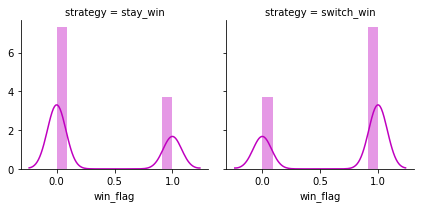

In [7]:
# prepare data for a side-by-side histogram
data_for_hist = pd.melt(data.loc[:,['stay_win', 'switch_win']], var_name = 'strategy', value_name = 'win_flag')
# build a histogram
g = sns.FacetGrid(data_for_hist, col = "strategy")
g = g.map(sns.distplot, "win_flag", color="m")

You can clearly see how switching strategy is better. To prove this point further, let's create another function that will calculate win rates for both strategies from a single trial and up to a given number of trials.

In [8]:
# calculate probabilities of win for every strategy starting from 1 trial to the maximum number of trials
def iterations(max_trials):
    trials = []
    stay = []
    switch = []
    for i in range(max_trials):
        trials.append(i + 1)
        gameplays = game(trials = i + 1)
        stay_temp = sum(gameplays.stay_win)/len(gameplays.stay_win)
        stay.append(stay_temp)
        switch_temp = sum(gameplays.switch_win)/len(gameplays.switch_win)
        switch.append(switch_temp)
    
    d = {'trials': trials, 'stay': stay, 'switch': switch}
    df = pd.DataFrame(data = d)
    df = pd.melt(df, id_vars = 'trials', 
                  var_name = 'strategy', value_name = 'probability_of_win')
    
    return df

Let's apply this function to games with 1 to 1000 of rounds. It will take a minute or so :) You can also try 10000, but it may take much longer

In [9]:
data = iterations(1000)

Text(0.5, 1.0, 'Monty Hall Problem Simulation: convergence to true probabilities')

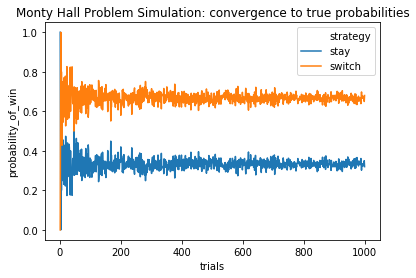

In [10]:
# build a lineplot for both strategies to display convergence
sns.lineplot(x = 'trials'
                , y = 'probability_of_win'
                , hue = 'strategy'
                , legend = 'full'
                , err_kws = {'alpha':0.3}
                , data = data)
ax = plt.gca()
ax.set_title('Monty Hall Problem Simulation: convergence to true probabilities')

You can see that the winning strategy of switching has a chance of 2/3 to win; Stay is only 1/3 